# WASP-121b phase curve fit

## Data download

In [21]:
from CONAN.get_files import get_TESS_data
%matplotlib inline

In [22]:
df = get_TESS_data("WASP-121")
df.search(author="SPOC", exptime=120)

SearchResult containing 6 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 07 2019   SPOC     120    22529346      0.0
  1 TESS Sector 33 2020   SPOC     120    22529346      0.0
  2 TESS Sector 34 2021   SPOC     120    22529346      0.0
  3 TESS Sector 61 2023   SPOC     120    22529346      0.0
  4 TESS Sector 87 2024   SPOC     120    22529346      0.0
  5 TESS Sector 88 2025   SPOC     120    22529346      0.0


the tutorial selects only the sector 7 data for a quick analysis

In [23]:
# df.download(sectors= [7,33,34,61], author="SPOC", exptime=120)
df.download(sectors= [7], author="SPOC", exptime=120, select_flux="sap_flux")

downloaded lightcurve for sector 7


the `CROWSAP` keyword in the header of the TESS fits file gives and estimate of the Ratio of target flux to total flux in aperture.  

We can use this to calculate the contamination fraction: the ratio of contaminating flux to target flux in the aperture. 

$F_{contam} = 1 - crowdsap$

$F_{target} = crowdsap$

contamination = $F_{contam}/F_{target}$

In [24]:
df.contam

{7: 0.09731933117289449}

we can choose the decontaminate the flux using this value or include it during the fitting.

to decontaminate, we can use the function within `CONAN` 

In [ ]:
# from CONAN.utils import decontaminate

# df.lc[7].flux  = decontaminate(df.lc[7].flux, df.contam[7])

we will instead include the contamination fraction during the fitting.

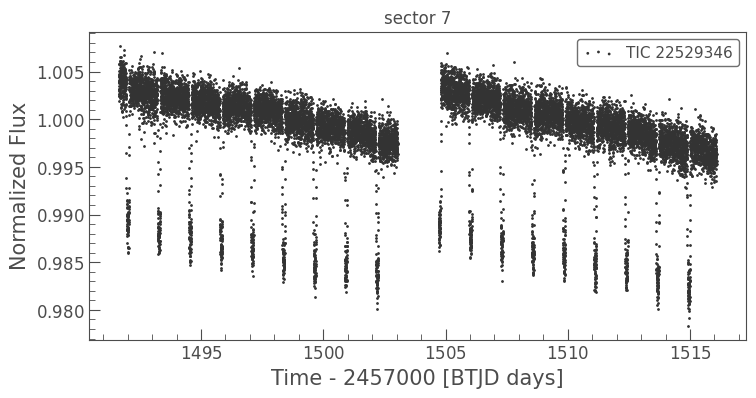

In [7]:
df.scatter()


to enable modeling the long-term baseline of the two orbits differently, we can split the orbits.

Sector 7 data splitted into 2 chunks: ['7_1', '7_2']


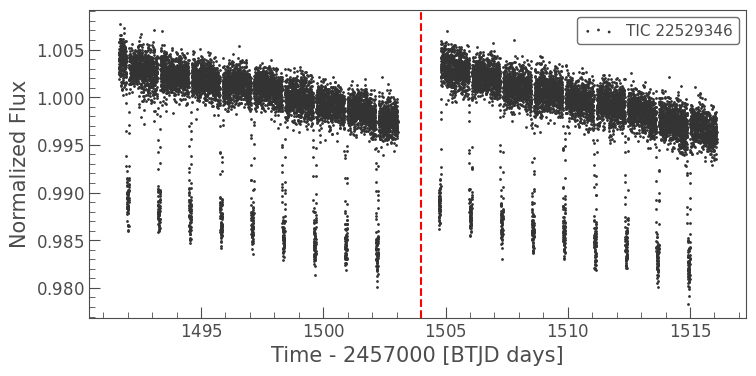

In [5]:
df.split_data(split_times=1504);

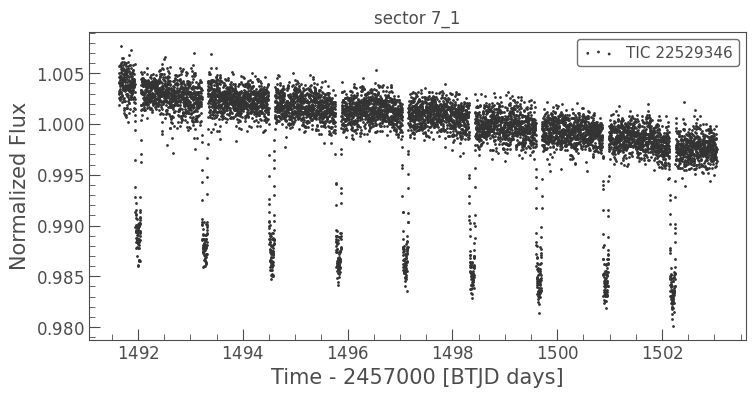

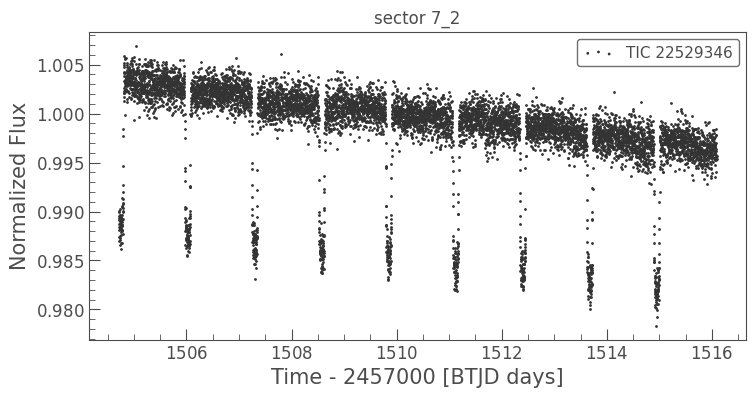

In [6]:
df.scatter()

In [12]:
df.save_CONAN_lcfile(bjd_ref=2457000)

saved file as: data/WASP-121_S7_1.dat
saved file as: data/WASP-121_S7_2.dat


## Data Analysis

In [5]:
from glob import glob
from os.path import basename

import numpy as np
import CONAN
import matplotlib.pyplot as plt
import pandas as pd
CONAN.__version__

'3.3.12'

### Setup light curve object

In [9]:
path = "data/"
lc_list  = ["WASP-121_S7_1.dat",
            "WASP-121_S7_2.dat",]

In [10]:
df = pd.read_fwf(path+lc_list[0], names=[f"col{i}" for i in range(9)])
df.head(5)

,col0,col1,col2,col3,col4,col5,col6,col7,col8
0,# time-2457000 flux,flux_err,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1491.63450126 1.00290573,0.00099943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1491.63589017 1.00320482,0.00099933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1491.63727908 1.00506699,0.00099932,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1491.63866798 1.00466049,0.00099920,NaN,NaN,NaN,NaN,NaN,NaN,NaN


load light curve into CONAN

In [11]:
lc_obj = CONAN.load_lightcurves(    file_list     = lc_list, 
                                    data_filepath = path, 
                                    filters       = ["T"], 
                                    wl            = [0.8],
                                    nplanet=1)
lc_obj

# ============ Input lightcurves, filters baseline function =======================================================
name              flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
WASP-121_S7_1.dat T   0.8  |None None         None    |  y    0    0    0    0    0    0    0|n    1 n  None           
WASP-121_S7_2.dat T   0.8  |None None         None    |  y    0    0    0    0    0    0    0|n    2 n  None           


lightcurves from filepath: data/
1 transiting planet(s)
Order of unique filters: ['T']

- The lc_obj object holds information now about the light curves. The light curves can be plotted using the `plot` method of the object.

By default this plots column 0 (time) against column 1 (flux) with column 3(flux err) as uncertainties. 

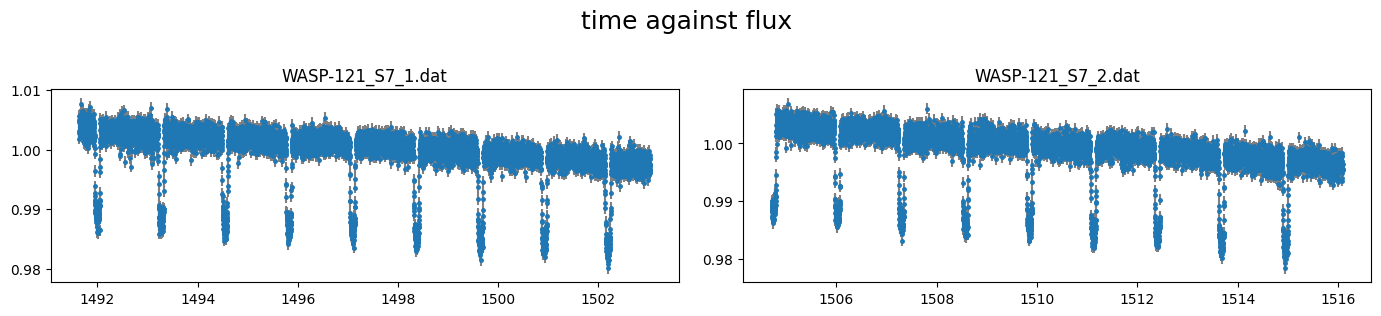

In [12]:
fig = lc_obj.plot(return_fig=True)

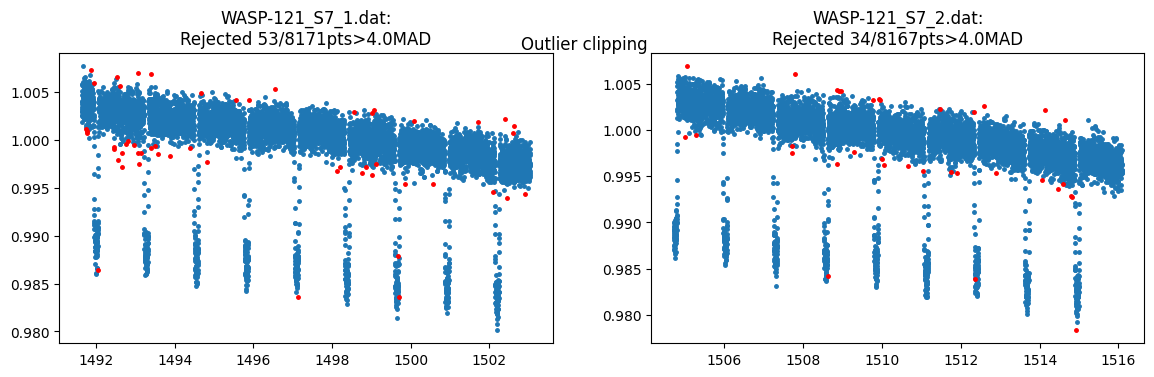

In [13]:
lc_obj.clip_outliers(clip=4, width=15, show_plot=True)


In [2]:
from CONAN.get_files import get_parameters
params = get_parameters("WASP-121 b")
params

Loading parameters from cache ...


{'star': {'Teff': (6776.0, 138.39),
  'logg': (4.24, 0.01),
  'FeH': (0.13, 0.09),
  'radius': (1.46, 0.03),
  'mass': (1.36, 0.07),
  'density': (0.61186, 0.05357)},
 'planet': {'name': 'WASP-121 b',
  'period': (1.27492504, 1.5e-07),
  'rprs': (0.12355, 0.00033),
  'mass': (1.157, 0.07),
  'ecc': (0.0, nan),
  'w': (10.0, 10.0),
  'T0': (2458119.72074, 0.00017),
  'b': (0.1, 0.01),
  'T14': (0.12105416666666667, 0.0002708333333333333),
  'aR': (nan, nan),
  'K[m/s]': (177.0, 8.5)}}

#### baseline and decorrelation parameters

- the baseline model for each lightcurve in the lc_obj object can be defined using the `lc_baseline` method
- However the `get_decorr` method can be used to automatically determine the best decorrelation parameters to use. (Based on least-squares fit to the data and bayes factor comparison)
- First, we need to define priors for the planet parameters and limb darkening


In [7]:
q1,q2 = lc_obj.get_LDs( Teff        = params["star"]["Teff"],
                        logg        = params["star"]["logg"],
                        Z           = params["star"]["FeH"],
                        filter_names= ["TESS"],
                        unc_mult    = 20)
q1,q2

TESS      (T): q1=(0.245, 0.028), q2=(0.3519, 0.0279)


([(0.245, 0.028)], [(0.3519, 0.0279)])

In [9]:
traocc_pars =dict(  T_0           = (params["planet"]["T0"][0]-2457000,params["planet"]["T0"][1]),
                    Period        = params["planet"]["period"],
                    Impact_para   = (0,params["planet"]["b"][0],0.5),
                    RpRs          = (0.1,params["planet"]["rprs"][0],0.15),
                    Duration      = params["planet"]["T14"],
                    D_occ         = (0,400,600),     #occultation depth in ppm
                    Fn            = (0,10,100),       #Nightside flux in ppm
                    ph_off        = (-7,0,7),       #Phase offset in degrees
                    A_ev          = (0,80,200)        #semi amplitude of ellipsoidal variation in ppm
                    )


The scatter in the differenced lightcurves is used to estimate the level of jitter present in the data and can be accessed using:

In [11]:
np.array(lc_obj._jitt_estimate)*1e6     # in ppm

array([513.33423946, 634.13728528])


getting decorr params for lc01: WASP-121_S7_1.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=513.3ppm)


BEST BIC:8105.54, pars:['offset', 'A0', 'B0']

getting decorr params for lc02: WASP-121_S7_2.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=634.1ppm)
BEST BIC:8012.80, pars:['offset', 'A0']

Setting-up parametric baseline model from decorr result
# ============ Input lightcurves, filters baseline function =======================================================
name              flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
WASP-121_S7_1.dat T   0.8  |None c1:W15C4n1   None    |  y    2    0    0    0    0    0    0|n    1 n  None           
WASP-121_S7_2.dat T   0.8  |None c1:W15C4n1   None    |  y    1    0    0    0    0    0    0|n    2 n  None           
Total number of baseline parameters: 5

Setting-up transit pars from input values
# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                       fit 	prior                             

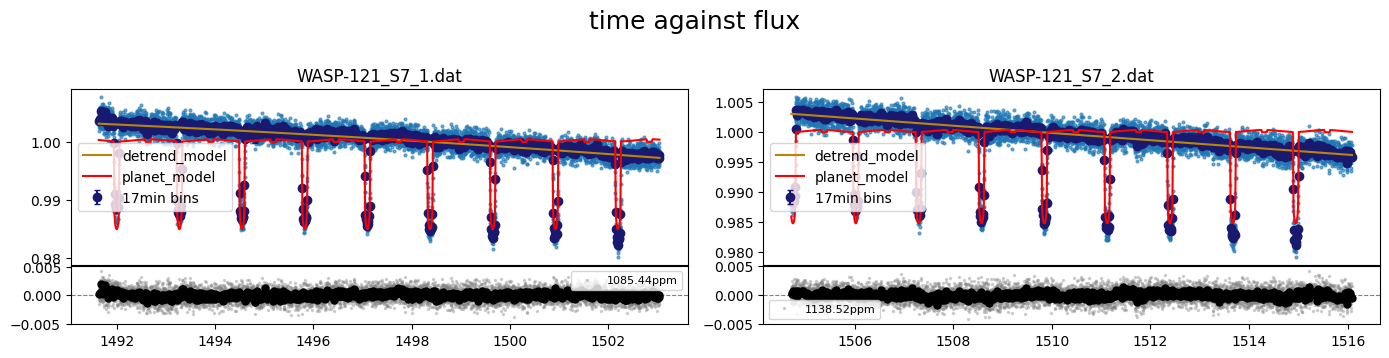

In [12]:
decorr_res = lc_obj.get_decorr( **traocc_pars, 
                                q1=q1, q2=q2,
                                exclude_cols    = [4,5,6,7,8], 
                                use_jitter_est  = True, 
                                setup_planet    = True)

In [13]:
decorr_res[0]

- manually define baseline for each lc

In [21]:
# lc_obj.lc_baseline(dcol0=2,gp = "n")

we can include the estimated contamination fraction

In [14]:
lc_obj.contamination_factors(cont_ratio=0.0973)

# ============ contamination setup (give contamination as flux ratio) ======================================== 
flt	contam_factor
T  	F(0.0973)           


In [15]:
lc_obj.print()

# ============ Input lightcurves, filters baseline function =======================================================
name              flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
WASP-121_S7_1.dat T   0.8  |None c1:W15C4n1   None    |  y    2    0    0    0    0    0    0|n    1 n  None           
WASP-121_S7_2.dat T   0.8  |None c1:W15C4n1   None    |  y    1    0    0    0    0    0    0|n    2 n  None           
# ============ Sinusoidal signals: Amp*trig(2𝜋/P*(x-x0)) - trig=sin or cos or both added==========================
name/filt         trig     n_harmonics  x     Amp[ppm]            P                   x0                
# ============ Photometry GP properties (start newline with name of * or + to Xply or add a 2nd gp to last file) =========
name/filt         kern  par    h1:[Amp]           h2:[len_scale1]    h3:[Q,η,C,α,b]     h4:[P]       
# ============ Planet parameters (Transit and RV) setup =======================

### Setup fit

In [16]:
fit_obj = CONAN.fit_setup(  R_st = params['star']['radius'],
                            apply_LCjitter="y",
                            LTT_corr = 'y'  # account for light travel time delay across the orbit
                            )
fit_obj.sampling(n_cpus=10, n_live=150)

# ============ Stellar input properties ======================================================================
# parameter     value 
Radius_[Rsun]  N(1.46,0.03)
Mass_[Msun]    N(None,None)
Input_method:[R+rho(Rrho), M+rho(Mrho)]: Rrho
# ============ FIT setup =====================================================================================
Number_steps                              2000 
Number_chains                             64 
Number_of_processes                       10 
Burnin_length                             500 
n_live                                    150 
force_nlive                               False 
d_logz                                    0.1 
Sampler(emcee/dynesty)                    dynesty 
emcee_move(stretch/demc/snooker)          stretch 
nested_sampling(static/dynamic[pfrac])    static 
leastsq_for_basepar(y/n)                  n 
apply_LCjitter(y/n,list)                  y 
apply_RVjitter(y/n,list)                  y 
LCjitter_loglims(auto/[lo,hi])      

### Save/Load configuration

we can export the configuration as both a `.dat` file and a `.yaml` file.

In [17]:
CONAN.create_configfile(lc_obj  = lc_obj, 
                        rv_obj  = None, 
                        fit_obj = fit_obj,
                        filename='WASP121_TESS_config.dat',
                        verify  = True)

configuration file saved as WASP121_TESS_config.dat
configuration file saved as WASP121_TESS_config.yaml


we can load back either the `.dat` or `.yaml` files to obtain the setup again

In [6]:
lc_obj, rv_obj, fit_obj = CONAN.load_configfile('WASP121_TESS_config.yaml')

### Performing the fit

we can examine the full set of parameters and priors for the fit

In [18]:
CONAN.get_parameter_names(lc_obj, rv_obj, fit_obj)[1]

{'Duration': 'N(0.12105416666666667,0.0002708333333333333)',
 'T_0': 'N(1119.720739999786,0.00017)',
 'RpRs': 'U(0.1,0.12355,0.15)',
 'Impact_para': 'U(0,0.1,0.5)',
 'Period': 'N(1.27492504,1.5e-07)',
 'T_DFocc': 'U(0,400,600)',
 'T_Fn': 'U(0,10,100)',
 'T_ph_off': 'U(-7,0,7)',
 'T_Aev': 'U(0,80,200)',
 'T_q1': 'N(0.2450,0.0280)',
 'T_q2': 'N(0.3519,0.0279)',
 'lc1_logjitter': 'U(-15.0000,-7.5746,-4.6390)',
 'lc2_logjitter': 'U(-15.0000,-7.3632,-4.6398)',
 'lc1_off': 'U(0.98014826,1,1.0077188)',
 'lc1_A0': 'U(-1,0,1)',
 'lc1_B0': 'U(-1,0,1)',
 'lc2_off': 'U(0.97918314,1,1.00584662)',
 'lc2_A0': 'U(-1,0,1)'}

Notice that there is a jitter for each lightcurve (`lc1_logjitter`, `lc2_logjitter`) as is the default in `CONAN`. However, since both lightcurves are from same TESS sector, they can share the same jitter. 

This can be done by configuring them as `shared_params` as a dictionary that maps one or several "recipient" parameters to one "donor" parameter in the format: ```shared_params = { donor : [recipient]}```

In [19]:
shared_params = {'lc1_logjitter': ['lc2_logjitter']}

we can confirm that `lc2_logjitter` is no longer a parameter to fit, as it now shares values with `lc1_logjitter`

In [22]:
CONAN.get_parameter_names(lc_obj, rv_obj, fit_obj,shared_params)[1]

{'Duration': 'N(0.12105416666666667,0.0002708333333333333)',
 'T_0': 'N(1119.720739999786,0.00017)',
 'RpRs': 'U(0.1,0.12355,0.15)',
 'Impact_para': 'U(0,0.1,0.5)',
 'Period': 'N(1.27492504,1.5e-07)',
 'T_DFocc': 'U(0,400,600)',
 'T_Fn': 'U(0,10,100)',
 'T_ph_off': 'U(-7,0,7)',
 'T_Aev': 'U(0,80,200)',
 'T_q1': 'N(0.2450,0.0280)',
 'T_q2': 'N(0.3519,0.0279)',
 'lc1_logjitter': 'U(-15.0000,-7.5746,-4.6390)',
 'lc1_off': 'U(0.98014826,1,1.0077188)',
 'lc1_A0': 'U(-1,0,1)',
 'lc1_B0': 'U(-1,0,1)',
 'lc2_off': 'U(0.97918314,1,1.00584662)',
 'lc2_A0': 'U(-1,0,1)'}

Finally, we perform the fitting which is saved to a `results` object that holds the sampling chains and allows subsequent plotting

In [23]:
result = CONAN.run_fit( lc_obj  = lc_obj, 
                        rv_obj  = rv_obj, 
                        fit_obj = fit_obj, 
                        shared_params = shared_params,
                        out_folder   = "result_WASP121", 
                        rerun_result = True);

Creating output folder...result_WASP121
configuration file saved as result_WASP121/config_save.dat
configuration file saved as result_WASP121/config_save.yaml

================ CONAN fit launched!!! ================

Setting up photometry arrays ...

Plotting prior distributions ...
----------------------------------

Generating initial model(s) ...
--------------------------- [0.78 secs]

Plotting initial model(s) ...
--------------------------- [6.23 secs]

Fit setup
----------
No of cpus: 10
No of dimensions: 17
fitting parameters:  ['Duration' 'T_0' 'RpRs' 'Impact_para' 'Period' 'T_DFocc' 'T_Fn'
 'T_ph_off' 'T_Aev' 'T_q1' 'T_q2' 'lc1_logjitter' 'lc1_off' 'lc1_A0'
 'lc1_B0' 'lc2_off' 'lc2_A0']
Shared parameters:  {'lc1_logjitter': ['lc2_logjitter']}

============ Samping started ... (using dynesty [static])======================
No of live points:  170


13167it [45:15,  4.85it/s, +170 | bound: 434 | nc: 1 | ncall: 483465 | eff(%):  2.760 | loglstar:   -inf < 87460.441 <    inf | logz: 87385.489 +/-  0.722 | dlogz:  0.001 >  0.100]



Dynesty chain written to disk as result_WASP121/chains_dict.pkl. Run `result=CONAN.load_result()` to load it.

============ Sampling Finished ==============================================[0.77hrs]

Making corner plot(s) ...
----> saved 2 corner plot(s) as result_WASP121/corner_*.png [9.98 secs]


Creating *out.dat files using the median posterior ...
    - Writing LC output to file: result_WASP121/out_data/WASP-121_S7_1_lcout.dat
    - Writing LC output to file: result_WASP121/out_data/WASP-121_S7_2_lcout.dat

 ----> Plotting figures using median posterior values ...[3.75 secs]

 ----> Plotting figures using max posterior values ...[3.52 secs]

Computing AIC, BIC stats ...[0.00 secs]

Computing photometric noise (red and white) correction factors ... [40.33308386802673 secs


['lc'] Output files, ['WASP-121_S7_1_lcout.dat', 'WASP-121_S7_2_lcout.dat'], loaded into result object
load_lightcurves(): input_lc is provided, using it to load lightcurves.
['rv'] Output files, [], loaded into

## Results

In [ ]:
import CONAN
import matplotlib.pyplot as plt
from CONAN.utils import bin_data, phase_fold

In [25]:
result =CONAN.load_result("result_WASP121")

['lc'] Output files, ['WASP-121_S7_1_lcout.dat', 'WASP-121_S7_2_lcout.dat'], loaded into result object
load_lightcurves(): input_lc is provided, using it to load lightcurves.
['rv'] Output files, [], loaded into result object
load_rvs(): input_rv is provided, using it to load rvs.
Linking the last created lightcurve object to the rv object for parameter linking. if this is not the related LC object, input the correct one using `lc_obj` argument of `load_rvs()`
.


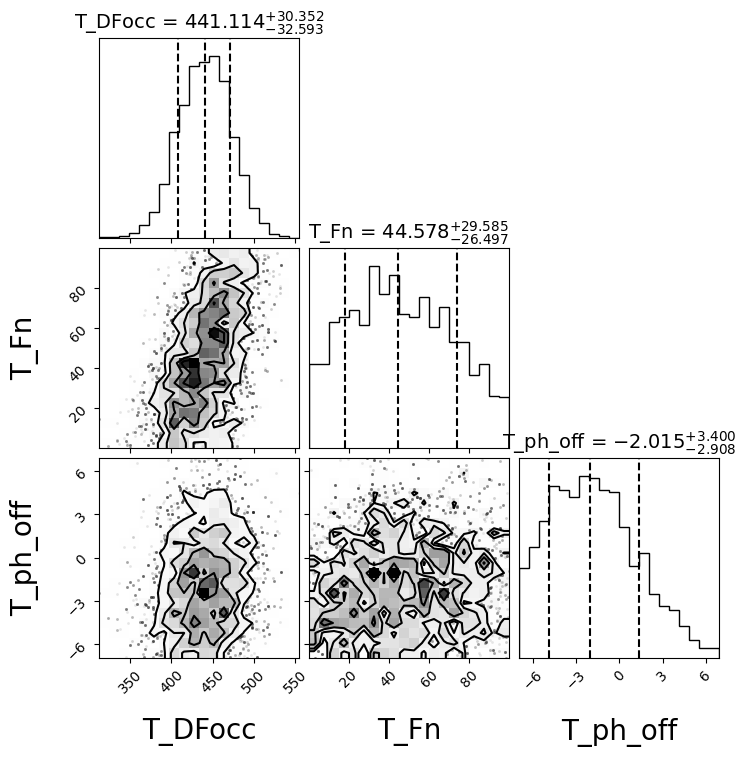

In [26]:
result.plot_corner(['T_DFocc', 'T_Fn', 'T_ph_off']);

In [31]:
result.params_dict

{'Duration': 0.12096762774345829+/-0.00015973513970569952,
 'T_0': 1119.7206454087868+/-6.678174133867287e-05,
 'RpRs': 0.12130404278518352+/-0.00023892596201999933,
 'Impact_para': 0.07416901671256881+/-0.0465637478339153,
 'Period': 1.2749249737678017+/-1.3548965083209907e-07,
 'T_DFocc': 441.19633269640065+/-31.696721584647378,
 'T_Fn': 44.533002348196014+/-28.35724453775935,
 'T_ph_off': -2.017930514129997+/-3.164099545433184,
 'T_Aev': 5.893275056750161+/-5.98263754405342,
 'T_q1': 0.19241814432464402+/-0.015489750290541754,
 'T_q2': 0.30864992169562017+/-0.0213733497059595,
 'lc1_logjitter': -7.502706188891717+/-0.01943533025929156,
 'lc1_off': 1.000597577832784+/-2.6675177079438228e-05,
 'lc1_A0': -0.0005204066701743892+/-3.1924381915238165e-06,
 'lc1_B0': -1.116321569216705e-05+/-1.2052121489691814e-06,
 'lc2_off': 0.9996200043258529+/-2.3190918743531963e-05,
 'lc2_A0': -0.000605945149427578+/-3.55729308937347e-06}

### LC

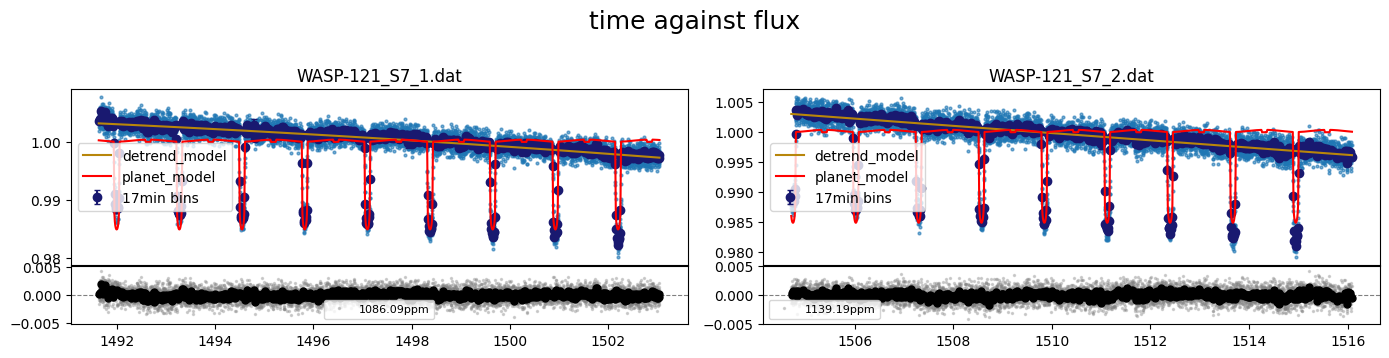

In [32]:
result.lc.plot_bestfit();

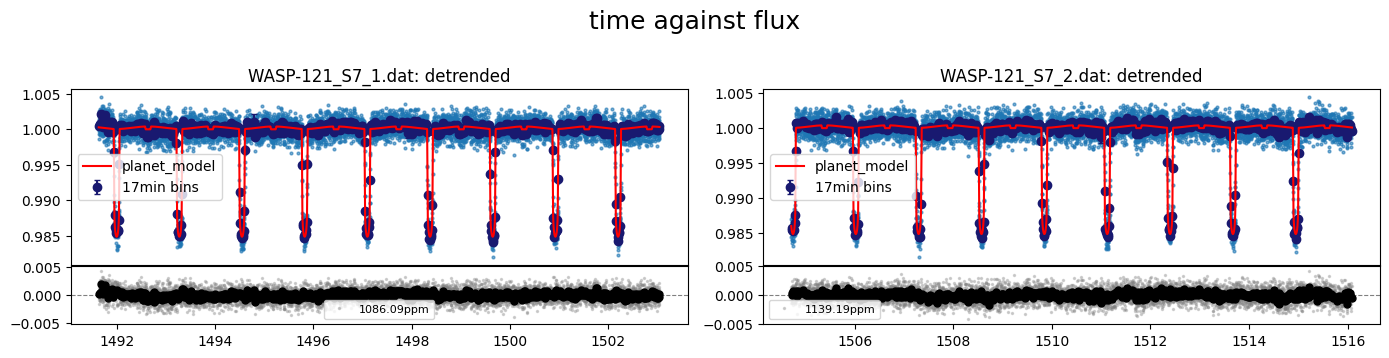

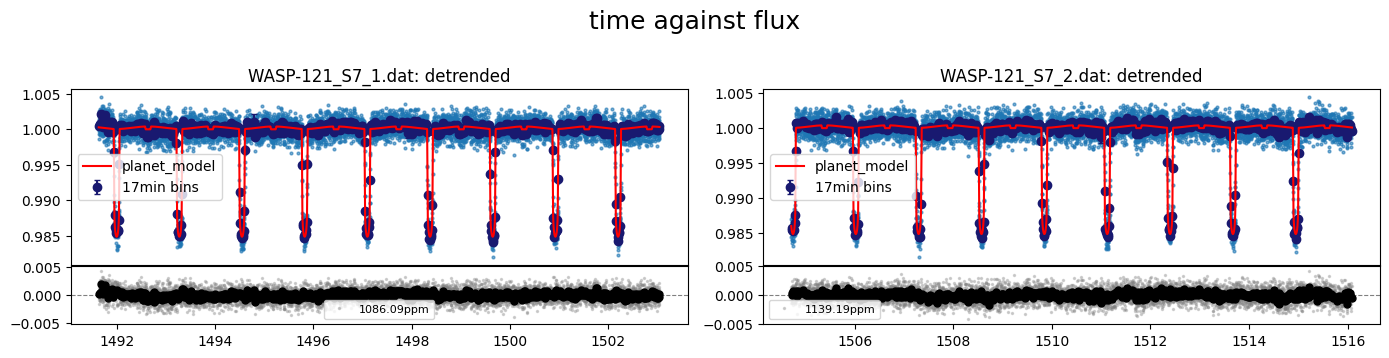

In [33]:
result.lc.plot_bestfit(detrend=True)